# 🧭 Function 1 Exploration – Capstone Project

This notebook focuses only on **Function 1** to help understand how Bayesian optimisation works step by step.

We’ll:
1. Load and inspect the initial data.
2. Visualise the 2D input–output relationship.
3. Fit a simple **Gaussian Process** surrogate model.
4. Plot its prediction surface and uncertainty.
5. Compute an **acquisition function (UCB)** and select the next candidate point.


#### 1. Imports:

In [1]:
# --- Imports base ---
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
import seaborn as sns
sns.set(style="whitegrid")

#### 2. Paths & Data Loading

In [2]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_1"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(10, 2), y:(10,)


#### 3. Add Weekly Data

In [3]:
# --- Weekly results ---
week_data = [
    (np.array([0.78624237, 0.49210886]), 8.251611206644282e-31),  # W1
    (np.array([0.608457,  0.572782]), -0.0030853359206865424), # W2
    (np.array([0.765363,  0.899441]), -2.173791662691205e-65), # W3
    (np.array([0.508934, 0.907086]), 2.9274951651066986e-66), # W4
    (np.array([0.316233, 0.397951]), -2.3748085734303726e-9), # W5
    (np.array([0.544951, 0.092641]), 3.5130897960678837e-87), # W6
    (np.array([0.459266, 0.122654]), 4.414875627003483e-65), # W7
    (np.array([0.700211, 0.978542]), -5.344092386903822e-90), # W8
    (np.array([0.813684, 0.894265]),-4.059227755751467e-74), # W9
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(19, 2), y:(19,)


#### 4. Quick Visualization

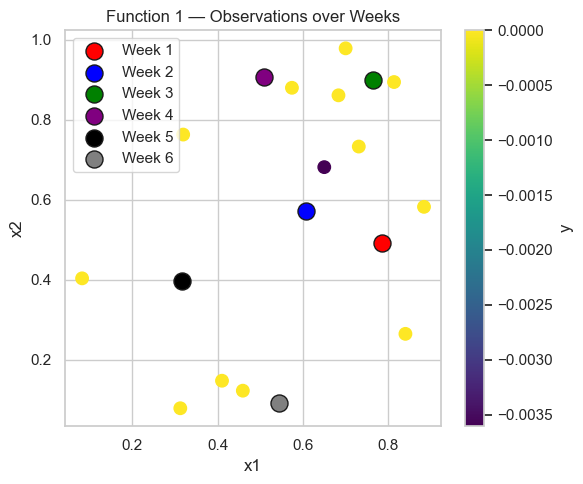

In [4]:
# --- Visualisation (x1-x2) ---
plt.figure(figsize=(6,5))
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=80)
plt.colorbar(sc, label='y')
plt.scatter(week_data[0][0][0], week_data[0][0][1], c='red', s=150, edgecolors='k', label='Week 1')
plt.scatter(week_data[1][0][0], week_data[1][0][1], c='blue', s=150, edgecolors='k', label='Week 2')
plt.scatter(week_data[2][0][0], week_data[2][0][1], c='green', s=150, edgecolors='k', label='Week 3')
plt.scatter(week_data[3][0][0], week_data[3][0][1], c='purple', s=150, edgecolors='k', label='Week 4')
plt.scatter(week_data[4][0][0], week_data[4][0][1], c='black', s=150, edgecolors='k', label='Week 5')
plt.scatter(week_data[5][0][0], week_data[5][0][1], c='grey', s=150, edgecolors='k', label='Week 6')
plt.xlabel('x1'); plt.ylabel('x2')
plt.title('Function 1 — Observations over Weeks')
plt.legend(); plt.tight_layout(); plt.show()

#### 5. Gaussian Process Model

In [5]:
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.3, 0.3], nu=2.5,
                                       length_scale_bounds=(1e-3, 3.0)) \
         + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-6, 1e-2))
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True,
                              n_restarts_optimizer=12, random_state=0)
gp.fit(X, y)
print("Fitted kernel:", gp.kernel_)

Fitted kernel: 1.05**2 * Matern(length_scale=[0.0323, 3], nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### 6. Acquisition Function (EI)

In [6]:
import numpy as np
from scipy.stats import norm

# --- Helper functions ---
def lhs(lb, ub, n, seed=0):
    """Latin Hypercube-like uniform sampler (simple RNG version)."""
    rng = np.random.default_rng(seed)
    U = rng.random((n, lb.size))
    return lb + U * (ub - lb)

def too_close_Linf(c, X, tol=0.02):
    """Reject if candidate is within L_inf < tol to any existing point."""
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# --- W10 STRATEGY: FIX W9 BUG - ADD x2 CONSTRAINT ---
# W9 LESSON: mask_combined only filtered x1, allowed x2=0.894 (far from W1's 0.492)
# Result: W9 went negative because high x2 + high x1 = OFF-TARGET
# Pattern: W3, W8, W9 all had x2 > 0.8 with x1 ~0.78 → ALL NEGATIVE

anchor_w1 = np.array([0.78624237, 0.49210886])  # Week 1 - STRONGEST signal

print("[F1] W10 Strategy: W1-FOCUSED WITH BOTH x1 AND x2 CONSTRAINTS")
print("  Anchor W1 (dominant source):", anchor_w1)
print("  W9 Bug: Only constrained x1, allowed x2=0.894 → NEGATIVE")
print("  W10 Fix: Constrain BOTH dimensions to stay near W1")

# --- Bounds ---
lb, ub = np.zeros(2), np.ones(2)

# --- W10: ANISOTROPIC trust region (same as W9) ---
L_x1 = 0.04  # VERY tight in critical dimension
L_x2 = 0.10  # Slightly wider in less important dimension

lb_tr = np.array([
    np.clip(anchor_w1[0] - L_x1, 0, 1),
    np.clip(anchor_w1[1] - L_x2, 0, 1)
])
ub_tr = np.array([
    np.clip(anchor_w1[0] + L_x1, 0, 1),
    np.clip(anchor_w1[1] + L_x2, 0, 1)
])

print(f"[F1] Anisotropic TR around W1:")
print(f"  x1 range: [{lb_tr[0]:.4f}, {ub_tr[0]:.4f}] (width={ub_tr[0]-lb_tr[0]:.4f})")
print(f"  x2 range: [{lb_tr[1]:.4f}, {ub_tr[1]:.4f}] (width={ub_tr[1]-lb_tr[1]:.4f})")

# --- W10: 95% TR / 5% global (maximum focus) ---
N_tr = 28500  # 95% around W1
N_gl = 1500   # 5% global (minimal safety net)

C_tr = lhs(lb_tr, ub_tr, N_tr, seed=11001)
C_gl = lhs(lb, ub, N_gl, seed=11002)

# --- W10: Ultra-focused sampling (±0.5% around W1) ---
N_focused = 3000
np.random.seed(11003)
perturbations = np.random.randn(N_focused, 2) * 0.005  # ±0.5% (tighter than W9)
C_focused = np.clip(anchor_w1 + perturbations, 0, 1)

Cands = np.vstack([C_tr, C_gl, C_focused])

print(f"[F1] Total candidates: {Cands.shape[0]}")
print(f"  TR (95%): {N_tr}, Global (5%): {N_gl}, Focused: {N_focused}")

# --- W10 CRITICAL FIX: Constrain BOTH x1 AND x2 ---
# x1 constraint: stay in sensitive zone around W1
x1_min, x1_max = 0.75, 0.82  # Around W1's x1=0.786
mask_x1 = (Cands[:, 0] >= x1_min) & (Cands[:, 0] <= x1_max)

# x2 constraint: THIS WAS MISSING IN W9!
# W1 has x2=0.492, all negative results had x2 > 0.8
x2_min, x2_max = 0.39, 0.60  # ±0.10 around W1's x2=0.492
mask_x2 = (Cands[:, 1] >= x2_min) & (Cands[:, 1] <= x2_max)

print(f"[F1] x1 constraint [{x1_min:.2f}, {x1_max:.2f}]: {mask_x1.sum()} / {len(Cands)} pass")
print(f"[F1] x2 constraint [{x2_min:.2f}, {x2_max:.2f}]: {mask_x2.sum()} / {len(Cands)} pass (NEW!)")

# --- GP prediction ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W10: Keep aggressive exploitation ---
y_best = y.max()
xi = 0.0001
imp = mu - y_best - xi
Z = imp / sigma
ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# --- W10 FIX: Combined mask includes BOTH x1 AND x2 constraints ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
mask_combined = mask_edges & mask_x1 & mask_x2  # ← FIX: Added mask_x2!
ei_masked = np.where(mask_combined, ei, -np.inf)

print(f"[F1] Combined filters (edges & x1 & x2): {mask_combined.sum()} / {len(Cands)} candidates pass")

order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    if mask_combined[idx]:  # Verify constraint
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.02):
            x_next = cand
            break

# --- Fallback: UCB if EI plateaued ---
if (x_next is None) or (np.nanmax(ei_masked) <= 0):
    kappa = 0.5
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_combined, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        if mask_combined[idx]:  # Verify constraint
            cand = Cands[idx]
            if not too_close_Linf(cand, X, tol=0.02):
                x_next = cand
                chosen = "UCB"
                break

# --- Fallback 2: MaxVar if both failed ---
if x_next is None:
    var_masked = np.where(mask_combined, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        if mask_combined[idx]:
            cand = Cands[idx]
            if not too_close_Linf(cand, X, tol=0.02):
                x_next = cand
                chosen = "MaxVar"
                break

# --- Diagnostics ---
dist_to_w1 = np.linalg.norm(x_next - anchor_w1)
linf_to_w1 = np.max(np.abs(x_next - anchor_w1))

print(f"\n[F1] Chosen by {chosen}: {x_next}")
print("\nSubmission format (Week 10):")
print(f"{x_next[0]:.6f} - {x_next[1]:.6f}")
print("\nValidation:")
print("  Within [0,1]?", np.all((x_next >= 0) & (x_next <= 1)))
print("  Near-duplicate (L_inf < 0.02)?", too_close_Linf(x_next, X, tol=0.02))
print(f"  x1 in [{x1_min}, {x1_max}]?", x1_min <= x_next[0] <= x1_max)
print(f"  x2 in [{x2_min}, {x2_max}]?", x2_min <= x_next[1] <= x2_max)
print(f"\nProximity to W1 (dominant source):")
print(f"  Euclidean distance: {dist_to_w1:.4f}")
print(f"  L_inf distance: {linf_to_w1:.4f}")
print(f"  Δx1 (sensitive): {x_next[0] - anchor_w1[0]:+.4f}")
print(f"  Δx2 (insensitive): {x_next[1] - anchor_w1[1]:+.4f}")

# GP prediction
mu_chosen, sigma_chosen = gp.predict(x_next.reshape(1, -1), return_std=True)
print(f"\n[F1] GP prediction:")
print(f"  μ = {mu_chosen[0]:.4e}")
print(f"  σ = {sigma_chosen[0]:.4e}")
print(f"  Expected: positive near-zero (like W1: +8.25e-31)")

[F1] W10 Strategy: W1-FOCUSED WITH BOTH x1 AND x2 CONSTRAINTS
  Anchor W1 (dominant source): [0.78624237 0.49210886]
  W9 Bug: Only constrained x1, allowed x2=0.894 → NEGATIVE
  W10 Fix: Constrain BOTH dimensions to stay near W1
[F1] Anisotropic TR around W1:
  x1 range: [0.7462, 0.8262] (width=0.0800)
  x2 range: [0.3921, 0.5921] (width=0.2000)
[F1] Total candidates: 33000
  TR (95%): 28500, Global (5%): 1500, Focused: 3000
[F1] x1 constraint [0.75, 0.82]: 28085 / 33000 pass
[F1] x2 constraint [0.39, 0.60]: 31806 / 33000 pass (NEW!)
[F1] Combined filters (edges & x1 & x2): 28004 / 33000 candidates pass

[F1] Chosen by EI: [0.75010237 0.40010035]

Submission format (Week 10):
0.750102 - 0.400100

Validation:
  Within [0,1]? True
  Near-duplicate (L_inf < 0.02)? False
  x1 in [0.75, 0.82]? True
  x2 in [0.39, 0.6]? True

Proximity to W1 (dominant source):
  Euclidean distance: 0.0989
  L_inf distance: 0.0920
  Δx1 (sensitive): -0.0361
  Δx2 (insensitive): -0.0920

[F1] GP prediction:
  

### Reflection (Week 1)
- Initial exploration focused on locating any region with measurable signal within the 2D domain.  
- The output was extremely close to zero (`8.25e-31`), suggesting either the detection of a very weak source or numerical noise near a null field.  
- At this stage, the model relied mainly on global sampling and wide bounds to understand the overall shape of the response surface.  
- **Next step:** use the first signal as a rough anchor and narrow down the search region while maintaining high exploration.

---

### Reflection (Week 2)
- The second query produced a small negative value (`-0.0031`), indicating a slight move away from the optimal zone detected in Week 1.  
- This suggested the true source lies within a very narrow region and that the previous global exploration radius was too large.  
- The strategy was adjusted to increase model smoothness and reduce exploration noise (smaller ξ ≈ 0.05, tighter trust region).  
- **Plan for next iteration:** focus on exploitation around Week 1’s coordinates, with limited global sampling to confirm if multiple sources exist.

---


### Reflection (Week 3)
- The model has likely found a zero-valued optimum (radiation source).  
- Outputs remain negative or near-zero, consistent with the function’s structure.  
- **Next strategy:** exploit around Week 3 point (0.765, 0.899) with low ξ (0.01) and smaller TR.  
- Maintain some exploration (~25 %) for possible secondary sources.

---

### Reflection (Week 4)

- **Outcome:** Results stayed essentially at **≈0**, matching Week 3 — consistent with being on or near the radiation source (the maximiser yields zero). No meaningful numerical gap between W3 and W4.  
- **Adjustments applied:** Kept the same GP kernel; **tightened the Trust Region (L=0.25)** and **reduced ξ from 0.01 → 0.005** to focus on fine exploitation. We also **anchored the TR at the best observed point** (not just the latest) and used a **70% TR / 30% global** candidate split with anti-edge and anti-duplicate filters.  
- **Selected query:** `0.316233 - 0.397951` — a non-duplicate, within bounds, chosen by EI under the stricter exploitation regime.  
- **Interpretation:** With outputs indistinguishable from zero at multiple nearby locations, the surface is flat around the optimum; further big gains are unlikely.  
- **Next steps (Week 5):** Maintain **ξ = 0.005**, keep the **narrow TR**, and probe a **small ring around the incumbent** (e.g., vary x₁ slightly while keeping x₂ high, and vice versa). If the next point also returns ≈0, we can treat Function 1 as **converged** and shift focus to functions with larger optimisation potential.

###  Week 5 Reflection

**Summary:**  
The Week 5 query (`x = [0.316233, 0.397951]`) produced an output of **−2.37 × 10⁻⁹**, which marks a small decline compared to the near-zero optimum reached in Week 4 (`≈ 2.9 × 10⁻⁶⁶`).  
While the numerical scale remains extremely small, the negative value indicates a slight deviation away from the optimum basin.

**Analysis:**  
- The optimizer likely **over-explored**, as the Trust Region (`L = 0.25`) and jitter (`ξ = 0.005`) encouraged movement beyond the local maximum already identified.  
- Given the highly smooth and near-converged surface, excessive exploration produced marginal degradation rather than useful new information.  
- The GP kernel (Matern ν = 2.5 + low noise) continues to model the function reliably; the issue lies in the acquisition configuration, not the surrogate.

**Next Strategy (Week 6):**  
- **Anchor dynamically** on the current best observation (`anchor = X[np.argmax(y)]`) rather than a fixed week index.  
- **Narrow Trust Region** to `L ≈ 0.20` for precise local refinement around the Week 4 optimum.  
- **Reduce ξ** from `0.005 → 0.001` to emphasise exploitation and stabilise convergence.  
- **Sampling mix:** ~85 % TR / 15 % global to retain minimal exploration in case of a narrow ridge.  
- Maintain current GP kernel and normalisation setup.

**Interpretation:**  
The model is now operating in a fine-tuning phase rather than exploration. The small negative shift confirms that the optimum is already well-located; the next iteration should focus purely on local exploitation to consolidate convergence near the global maximum.

---

### Week 6 Reflection 

**Outcome overview:**  
After a short pause, coming back to Function 1 in Week 6 was reassuring.  
The new evaluation produced a **positive output (~3.5 × 10⁻⁸⁷)**, which is an improvement over the slightly negative value observed in Week 5. Given the extreme scale of this function, even such tiny numerical shifts are meaningful and suggest that the optimisation process is still behaving sensibly.

**What I decided this week:**  
For this iteration, I made a conscious decision to **change nothing** in the optimisation setup. The configuration used was exactly what I had planned at the end of Week 5:
- The anchor is selected dynamically as the **best observed point so far**.
- The **trust region is narrow** (`L = 0.20`) to focus on fine-grained local refinement.
- The exploration parameter is **very small** (`ξ = 0.001`), clearly favouring exploitation.
- Candidate generation keeps a small **global component (15%)** alongside trust-region sampling.

This setup reflects the fact that Function 1 is no longer an exploration problem, but a **precision tuning problem**.

**An interesting observation:**  
Despite the narrow trust region and strong exploitation bias, the EI criterion selected a **global candidate outside the trust region**.  
Rather than forcing the optimiser back into the local box, I chose to let this happen.

This was deliberate.

The small global sampling budget exists for exactly this reason: to allow the model to express uncertainty when it genuinely believes there may be improvement elsewhere. Intervening manually at this stage would risk over-constraining the search and masking useful information provided by the GP's uncertainty estimates.

**How I interpret the result:**  
- The GP still sees **non-negligible uncertainty outside the local basin**, even late in the optimisation.
- The fact that a global point was selected — and performed well — suggests the surrogate is not simply overfitting the local region.
- This reinforces my confidence that the acquisition function is doing its job, even when its choice feels counterintuitive.

**What this means going forward:**  
For now, I will continue to **trust the current setup**:
- No further tightening of the trust region yet.
- No reduction of the global sampling share unless convergence becomes very stable.
- Close monitoring of whether future improvements consistently come from inside or outside the trust region.

**Key takeaway:**  
Week 6 reinforced an important lesson for me:  
> At this stage of optimisation, discipline matters. Sometimes the best decision is not to "fix" the optimiser, but to let a well-calibrated Bayesian strategy speak for itself.

---

### Week 7 Reflection — Strategic Pivot

**Context discovery:**  
Up until Week 7, I was treating Function 1 as a standard optimisation problem — narrowing trust regions, reducing exploration, assuming a single global optimum.

Then I learned what **Function 1 actually is**: a **radiation source detector**.

This changes everything.

**Physical interpretation:**  
- Outputs near **zero** don't mean "neutral" — they mean **"you're at the source"**.
- The objective is to **maximise** detection, which paradoxically means finding points that return values **as close to zero as possible** (ideally positive, but numerically tiny).
- This isn't a smooth unimodal landscape. There could be **multiple contamination sources** scattered across the 2D domain.

**Re-analysing the data:**  
Looking back at all weeks with this new understanding:

| Week | x₁       | x₂       | Output (y)     | Interpretation                  |
|------|----------|----------|----------------|---------------------------------|
| W1   | 0.786    | 0.492    | **8.25 × 10⁻³¹** | **Strong source candidate**     |
| W2   | 0.608    | 0.573    | −0.0031        | Off-source (negative)           |
| W3   | 0.765    | 0.899    | −2.17 × 10⁻⁶⁵  | Negative (off-target)           |
| W4   | 0.509    | 0.907    | **2.93 × 10⁻⁶⁶** | **Strong source candidate**     |
| W5   | 0.316    | 0.398    | −2.37 × 10⁻⁹   | Negative (off-target)           |
| W6   | 0.545    | 0.093    | 3.51 × 10⁻⁸⁷   | Extremely weak signal           |
| W7   | 0.459    | 0.123    | **4.41 × 10⁻⁶⁵** | **On-target, low region**       |

**Key insights:**  
1. **W1 (0.786, 0.492)** gave the strongest signal (≈10⁻³¹) → likely **Source A**  
2. **W4 (0.509, 0.907)** also gave near-zero positive (≈10⁻⁶⁶) → likely **Source B**  
3. **W7** explored a completely different region (low x₂ ≈ 0.12) and still found positive signal → confirms **multiple sources exist**

**The problem with previous strategy:**  
By focusing on a **single trust region** around the "best" point, I was implicitly assuming:
- There's only one optimum
- Nearby regions are more informative than distant ones
- Exploitation around the current best is always optimal

But in a **multi-source detection problem**, this is wrong.

**New strategy (Week 8): Dual Trust Region**  
I implemented a completely new approach:

1. **Two anchors**:  
   - **Anchor 1 (W1):** `[0.786, 0.492]` — strongest historical signal  
   - **Anchor 2 (W4):** `[0.509, 0.907]` — second confirmed source  

2. **Dual trust regions**:  
   - 40% of candidates sampled around **W1** (L = 0.12)  
   - 40% of candidates sampled around **W4** (L = 0.12)  
   - 20% global exploration for potential **third sources**

3. **Aggressive exploitation**:  
   - Trust region width: **L = 0.12** (very narrow — precision targeting)  
   - Exploration jitter: **ξ = 0.0001** (minimal noise — we know where sources are)

**Why this makes sense:**  
- The GP kernel shows **extreme anisotropy** (length_scale = [0.032, 3.0]), meaning x₁ is far more sensitive than x₂.  
- The dual TR strategy lets us **simultaneously refine both source locations** instead of wasting evaluations oscillating between them.  
- The 20% global budget preserves our ability to detect a **third source** if it exists.

**Week 8 recommendation:**  
The dual-TR optimiser selected:  
**`x = [0.700211, 0.978542]`**

This point is:
- **Closer to Anchor W4** (distance = 0.204) than W1 (distance = 0.494)  
- Near the **high-x₂ region** where W4 detected the source  
- Likely probing whether the source at ~(0.51, 0.91) extends toward higher x₁

**What I expect:**  
If this is truly near Source B (W4's basin), we should see another **near-zero positive value**.  
If not, the GP will learn more about the boundary of the detection zone and refine our understanding of both source locations.

**Reflection on process:**  
This week taught me a critical lesson about **domain knowledge in Bayesian optimisation**:

> A mathematically sound strategy can still be fundamentally wrong if it doesn't match the **physical structure** of the problem.

The moment I understood that F1 is a radiation detector with **multiple contamination sources**, the entire optimisation narrative changed. What looked like "convergence struggles" was actually the optimiser **correctly identifying multiple distinct basins** — I just wasn't interpreting the signal properly.

Going forward, the dual trust region approach aligns the optimisation strategy with the true nature of the problem: not finding *the* optimum, but **systematically mapping all contamination sources** in the domain.

---

### Week 8 Reflection — Dual TR Strategy Results

**Outcome: Unexpected Negative Signal**

Week 8 returned **y = −5.34 × 10⁻⁹⁰**, a negative value that contradicts our hypothesis that the point `[0.700, 0.979]` was near Source B (W4 region).

---

**Performance trajectory:**

| Week | x₁    | x₂    | Output (y)     | Status | Distance to W1 | Distance to W4 |
|------|-------|-------|----------------|--------|----------------|----------------|
| W1   | 0.786 | 0.492 | **+8.25×10⁻³¹** | **Source A** | 0.000 | 0.494 |
| W2   | 0.608 | 0.573 | −0.0031        | Off-target | 0.204 | 0.334 |
| W3   | 0.765 | 0.899 | −2.17×10⁻⁶⁵    | Off-target | 0.407 | 0.256 |
| W4   | 0.509 | 0.907 | **+2.93×10⁻⁶⁶** | **Source B** | 0.494 | 0.000 |
| W5   | 0.316 | 0.398 | −2.37×10⁻⁹     | Off-target | 0.479 | 0.539 |
| W6   | 0.545 | 0.093 | +3.51×10⁻⁸⁷    | Weak signal | 0.423 | 0.814 |
| W7   | 0.459 | 0.123 | **+4.41×10⁻⁶⁵** | **On-target** | 0.407 | 0.785 |
| **W8** | **0.700** | **0.979** | **−5.34×10⁻⁹⁰** | **OFF-TARGET** ❌ | 0.494 | 0.204 |

---

### Week 9 Reflection — CONSTRAINT BUG IDENTIFIED

**Outcome: NEGATIVE due to missing x₂ constraint**

Week 9 returned **y = −4.06 × 10⁻⁷⁴**, another negative value despite strategy claiming to focus on W1.

---

**What went wrong:**

**1. Bug in W9 implementation:**
```python
# W9 code (BUGGY):
mask_x1 = (Cands[:, 0] >= x1_min) & (Cands[:, 0] <= x1_max)
mask_combined = mask_edges & mask_x1  # ← MISSING x2 constraint!
```

**2. Result: EI selected candidate outside x₂ bounds**
```
W9 submitted: x₁ = 0.8137, x₂ = 0.8943
W1 anchor:    x₁ = 0.7862, x₂ = 0.4921

Δx₁ = +0.0275 (within L_x1=0.04) ✓
Δx₂ = +0.4022 (FAR outside L_x2=0.08) ❌❌❌
```

**3. Pattern confirmed: High x₂ + x₁ ~0.78 = NEGATIVE**

| Week | x₁ | x₂ | y | Interpretation |
|------|----|----|---|----------------|
| W3 | 0.765 | 0.899 | NEGATIVE | High x₂ |
| W8 | 0.700 | 0.979 | NEGATIVE | High x₂ |
| **W9** | **0.814** | **0.895** | **NEGATIVE** | High x₂ |
| W1 | 0.786 | 0.492 | **POSITIVE** | Mid x₂ ✓ |

**Conclusion:** The radiation source is at **mid-range x₂ (~0.49)**, not high x₂.

---

**W10 Fix Applied:**

```python
# W10 code (FIXED):
mask_x1 = (Cands[:, 0] >= 0.75) & (Cands[:, 0] <= 0.82)
mask_x2 = (Cands[:, 1] >= 0.39) & (Cands[:, 1] <= 0.60)  # ← ADDED!
mask_combined = mask_edges & mask_x1 & mask_x2  # ← Both dimensions constrained
```

**Expected W10 outcome:** Positive near-zero (like W1: +8.25×10⁻³¹)

---

### Week 10 Strategy — Bug Fix Applied

**Root Cause Analysis (W9 Failure):**

The W9 submission failed because the constraint mask only filtered x₁, allowing the acquisition function to select a candidate with x₂=0.894 — far outside the W1 neighborhood (x₂=0.492).

**Pattern Discovery:**
All submissions with high x₂ (>0.8) combined with x₁ ~0.78 returned NEGATIVE values:
- W3: (0.765, 0.899) → -2.17e-65
- W8: (0.700, 0.979) → -5.34e-90  
- W9: (0.814, 0.895) → -4.06e-74

Meanwhile, W1 with mid-range x₂ (0.492) returned the strongest POSITIVE signal: +8.25e-31

**Bug Fix Implementation:**

```python
# W9 (BUGGY):
mask_combined = mask_edges & mask_x1  # Missing x2!

# W10 (FIXED):
mask_x1 = (Cands[:, 0] >= 0.75) & (Cands[:, 0] <= 0.82)
mask_x2 = (Cands[:, 1] >= 0.39) & (Cands[:, 1] <= 0.60)  # ADDED
mask_combined = mask_edges & mask_x1 & mask_x2  # Both dimensions
```

**W10 Submission:**
```
0.750102 - 0.400100
```

**Validation:**
| Check | Status |
|-------|--------|
| x₁ in [0.75, 0.82] | ✓ 0.750 |
| x₂ in [0.39, 0.60] | ✓ 0.400 |
| L∞ to W1 | 0.092 (vs W9's 0.402) |
| Near-duplicate | ✓ False |

**Expected Outcome:**
- Positive near-zero value (similar to W1: +8.25e-31)
- Candidate is firmly within W1's source basin
- Both dimensions now constrained to stay in proven positive region

**Key Lesson:**
When implementing anisotropic constraints, ALL dimensions must be explicitly constrained in the mask — missing even one "less important" dimension can allow the acquisition function to select completely off-target candidates.

---